In [2]:
import torch, math
import numpy as np
from scipy.integrate import simps
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from math import factorial, sqrt, pi
import torch
import functorch

In [3]:
import importlib
import Master_funcs
importlib.reload(Master_funcs)

<module 'Master_funcs' from '/Users/aleksandersekkelsten/UIO/FYS4480/Master_funcs.py'>

In [48]:
def train_model(V,E,f_net,optimizer,N_collocation=200,n_epochs=800, sdt_dev=0.2,factor=5):
    n_permutations = 6
    V_temp=V/factor
    i=0
    sign = np.sign(V)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        x = torch.normal(0.0, sdt_dev, size=(N_collocation,n_particles,d))
        SD = slater_determinant_from_C_occ_batch(x, C_occ)
        
        perm_list = [torch.randperm(n_particles) for _ in range(n_permutations)]
        f_out= symmetrized_exp_nn_output(f_net, x, n_permutations=n_permutations)
        f_out=f_out.reshape(len(f_out))
        
        psi = SD * f_out
        norm=torch.norm(psi, p=2)
        
        laplacian = compute_laplacian_fast(psi_fn, x, permutations=perm_list)#compute_laplacian_fast(psi_fn, x)
        V_harmonic = 0.5 * (x**2).sum(dim=(1,2)).view(-1,1)
        V_int = compute_interaction_potential(x, V_temp, sigma)
        V_total = V_harmonic + V_int
        H_psi = -0.5 * laplacian + V_total * psi
        residual = H_psi - (E)*psi

        norm_loss = (psi.norm() - 1)**2*0.1
        loss_pde = torch.mean((residual)**2)*100/norm**2
        loss = loss_pde + norm_loss #+ loss_sym

        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch:05d}:  Pde Loss = {loss_pde.item():.3e}, "
                  f"Norm Loss = {norm_loss.item():.3e}")#,  = {E_param.item():.3f}")
            if epoch%100 == 0:
                i+=sign*0.5
                V_temp = V_temp+i
                V_temp = sign*min(abs(V),abs(V_temp))
    return f_net

In [5]:
def symmetrized_nn_output(NN, x, n_permutations=10, permutations=None):
    """
    Enforces permutation symmetry by averaging NN outputs over several 
    permutations of the particle indices.
    
    Args:
        NN: A callable neural network that accepts input x of shape 
            (batch, n_particles, d).
        x: Tensor of shape (batch, n_particles, d).
        n_permutations: Number of permutations to average over.
        permutations: (Optional) A list of precomputed permutation indices of length n_permutations.
        
    Returns:
        A tensor with the averaged (symmetrized) output.
    """
    batch_size, n_particles, _ = x.shape
    outputs = []
    
    if permutations is None:
        # If no permutations are provided, generate them (not recommended within vmap)
        for _ in range(n_permutations):
            perm = torch.randperm(n_particles)
            outputs.append(NN(x[:, perm, :]))
    else:
        for perm in permutations:
            outputs.append(NN(x[:, perm, :]))
    
    outputs = torch.stack(outputs, dim=0)  # shape: (n_permutations, batch, output_dim)
    return outputs.mean(dim=0)

def symmetrized_exp_nn_output(NN, x, n_permutations=10, permutations=None):
    """
    Applies the exponential to the symmetrized NN output,
    implementing f(x)=exp(NN(x)).
    """
    return torch.exp(symmetrized_nn_output(NN, x, n_permutations, permutations))

def compute_laplacian_fast(psi_fn, x, permutations=None):
    """
    Compute the Laplacian of psi for a batch of configurations using functorch.jacrev.
    
    Args:
        psi_fn: A function mapping a single configuration x (shape: (n_particles, d))
                to a scalar psi (0-dim tensor). Must be pure.
        x: Tensor of shape (batch, n_particles, d) with requires_grad=True.
        permutations: (Optional) Precomputed list of permutation indices.
        
    Returns:
        Tensor of shape (batch, 1) containing the Laplacian of psi.
    """
    batch, n_particles, d = x.shape
    D = n_particles * d
    # Flatten each configuration to shape (D,)
    x_flat = x.view(batch, D)
    
    def f(xx):
        # Reshape xx to (n_particles, d) and compute psi.
        return psi_fn(xx.view(n_particles, d), permutations=permutations)
    
    def single_hessian(xx):
        # Compute the Hessian via double jacrev.
        return torch.func.jacrev(functorch.jacrev(f))(xx)
    
    # Vectorize single_hessian over the batch dimension.
    hessians = torch.vmap(single_hessian)(x_flat)  # shape: (batch, D, D)
    # Laplacian is the trace of the Hessian.
    laplacian = torch.diagonal(hessians, dim1=1, dim2=2).sum(dim=1, keepdim=True)
    return laplacian

def psi_fn(x_single, permutations=None):
    """
    Compute the wavefunction for a single configuration.
    
    Args:
        x_single: Tensor of shape (n_particles, d) with requires_grad=True.
        permutations: (Optional) Precomputed list of permutation indices.
    
    Returns:
        A scalar tensor representing psi.
    """
    # Add a batch dimension: shape (1, n_particles, d)
    x_batch = x_single.unsqueeze(0)
    SD_val = slater_determinant_from_C_occ_batch(x_batch, C_occ)  # Assumed to be defined globally.
    # Use the symmetrized exponential NN output.
    f_val = symmetrized_exp_nn_output(f_net, x_batch, n_permutations=10, permutations=permutations)
    psi_val = (SD_val * f_val).squeeze()  # Return a scalar tensor.
    return psi_val

In [6]:
def slater_determinant_from_C_occ(x_config, C_occ, normalize=True):
    """
    Compute the Slater determinant for each configuration in a differentiable manner.
    
    Args:
        x_config: Tensor of shape (batch, n_electrons, d) with electron positions (assume d=1).
        C_occ:    Tensor of shape (n_basis, n_electrons) containing the occupied orbital coefficients.
        normalize: If True, include the factor 1/sqrt(n_electrons!).
        
    Returns:
        Tensor of shape (batch, 1) with the Slater determinant value for each configuration.
    """
    batch, n_electrons, d = x_config.shape
    n_basis = C_occ.shape[0]
    SD_vals = []
    
    for i in range(batch):
        # Extract positions for configuration i; shape (n_electrons,)
        x_i = x_config[i, :, 0]  # assuming d = 1
        # Evaluate basis functions at these positions; shape (n_electrons, n_basis)
        phi_vals = evaluate_basis_functions_torch(x_i, n_basis)
        # Build the molecular orbital matrix:
        # Each molecular orbital is a linear combination: psi_j(x) = sum_p phi_p(x)*C_occ[p, j]
        # For all electrons, this is: psi_mat = phi_vals @ C_occ, shape (n_electrons, n_electrons)
        psi_mat = torch.matmul(phi_vals, C_occ)
        # Compute the determinant in a differentiable manner.
        # You can use torch.linalg.det or (for stability) torch.linalg.slogdet.
        det_val = torch.linalg.det(psi_mat)
        SD_vals.append(det_val)
    
    SD_vals = torch.stack(SD_vals).view(batch, 1)
    if normalize:
        SD_vals = SD_vals / math.sqrt(math.factorial(n_electrons))
    return SD_vals
def evaluate_basis_functions_torch(x, n_basis):
    """
    Evaluate the 1D harmonic oscillator eigenfunctions at positions x in a differentiable manner.
    
    Args:
        x: Tensor of shape (N,), where N is the number of positions.
        n_basis: Number of basis functions to evaluate.
        
    Returns:
        Tensor of shape (N, n_basis) where each column is one basis function evaluated at x.
    """
    N = x.shape[0]
    phi_vals = []  # will hold each phi_n evaluated at x
    # For n = 0:
    norm0 = 1.0 / math.sqrt(math.sqrt(math.pi))
    phi0 = norm0 * torch.exp(-x**2 / 2)
    phi_vals.append(phi0)
    
    if n_basis > 1:
        # For n = 1:
        norm1 = 1.0 / math.sqrt(2 * math.sqrt(math.pi))
        phi1 = norm1 * (2 * x) * torch.exp(-x**2 / 2)
        phi_vals.append(phi1)
    
    # For higher n, use recurrence for Hermite polynomials:
    # H_0(x) = 1, H_1(x) = 2x, and for n>=1: H_{n+1}(x) = 2x H_n(x) - 2n H_{n-1}(x)
    if n_basis > 2:
        H_prev_prev = torch.ones_like(x)  # H_0(x)
        H_prev = 2 * x                     # H_1(x)
        for n in range(1, n_basis - 1):
            H_curr = 2 * x * H_prev - 2 * n * H_prev_prev
            # Normalization: 1/sqrt(2^n n! sqrt(pi))
            norm = 1.0 / math.sqrt((2**(n+1)) * math.factorial(n+1) * math.sqrt(math.pi))
            phi_n = norm * torch.exp(-x**2 / 2) * H_curr
            phi_vals.append(phi_n)
            H_prev_prev, H_prev = H_prev, H_curr

    # Stack along the second dimension: shape (N, n_basis)
    phi_vals = torch.stack(phi_vals, dim=1)
    return phi_vals

In [7]:
def compute_interaction_potential(x, V, sigma):
    batch_size, n_particles, d = x.shape
    V_int = torch.zeros(batch_size, device=x.device)
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            r = x[:, i, :] - x[:, j, :]
            r_sq = (r**2).sum(dim=1)
            V_int += torch.exp(-r_sq / (2 * sigma**2))
    return (V / (sigma * np.sqrt(2 * np.pi))) * V_int.view(-1, 1)

def psi_plot_fn(positions):
    # positions: Tensor of shape (batch, n_particles, 1)
    SD_vals = slater_determinant_from_C_occ(positions, C_occ)   # (batch, 1)
    f_vals  = symmetrized_exp_nn_output(f_net, positions, n_permutations=10)#f_net(positions).view(-1, 1)                        # (batch, 1)
    return SD_vals * f_vals   # (batch, 1)


In [8]:
def evaluate_basis_functions_torch_batch(x, n_basis):
    """
    Batched evaluation of 1D harmonic oscillator eigenfunctions.
    
    Args:
        x: Tensor of shape (B, N) with electron positions.
        n_basis: Number of basis functions to evaluate.
        
    Returns:
        Tensor of shape (B, N, n_basis) where each column is one basis function.
    """
    B, N = x.shape  # B=batch, N = number of electrons
    # Precompute the Gaussian factor (shape: (B, N))
    gauss = torch.exp(-x**2 / 2)
    
    # Precompute normalization factors
    norm0 = 1.0 / math.sqrt(math.sqrt(math.pi))
    phi0 = norm0 * gauss  # shape: (B, N)
    
    phi_list = [phi0]
    
    if n_basis > 1:
        norm1 = 1.0 / math.sqrt(2 * math.sqrt(math.pi))
        phi1 = norm1 * (2 * x) * gauss
        phi_list.append(phi1)
    
    if n_basis > 2:
        # Use vectorized recurrence for Hermite polynomials.
        H_prev_prev = torch.ones_like(x)  # H_0
        H_prev = 2 * x                     # H_1
        for n in range(1, n_basis - 1):
            H_curr = 2 * x * H_prev - 2 * n * H_prev_prev
            norm = 1.0 / math.sqrt((2**(n+1)) * math.factorial(n+1) * math.sqrt(math.pi))
            phi_n = norm * gauss * H_curr  # shape: (B, N)
            phi_list.append(phi_n)
            H_prev_prev, H_prev = H_prev, H_curr

    # Stack basis functions along a new last dimension -> shape: (B, N, n_basis)
    phi_vals = torch.stack(phi_list, dim=-1)
    return phi_vals

def slater_determinant_from_C_occ_batch(x_config, C_occ, normalize=True):
    """
    Compute the Slater determinant in a fully batched manner.
    
    Args:
        x_config: Tensor of shape (B, n_electrons, d), here assume d = 1,
                  so you can squeeze it to (B, n_electrons).
        C_occ:    Tensor of shape (n_basis, n_electrons) containing occupied orbital coefficients.
        normalize: If True, include the factor 1/sqrt(n_electrons!).
        
    Returns:
        Tensor of shape (B, 1) with the Slater determinant value for each configuration.
    """
    B, n_electrons, d = x_config.shape
    # For d=1, squeeze out the last dimension.
    x = x_config.squeeze(-1)  # shape: (B, n_electrons)
    n_basis = C_occ.shape[0]
    
    # Evaluate basis functions for all configurations at once.
    # phi_vals has shape (B, n_electrons, n_basis)
    phi_vals = evaluate_basis_functions_torch_batch(x, n_basis)
    
    # Build the molecular orbital matrix for each configuration.
    # psi_mat: (B, n_electrons, n_basis) @ (n_basis, n_electrons) -> (B, n_electrons, n_electrons)
    psi_mat = torch.matmul(phi_vals, C_occ)
    
    # Compute determinants in batch.
    det_vals = torch.linalg.det(psi_mat).view(B, 1)
    
    if normalize:
        det_vals = det_vals / math.sqrt(math.factorial(n_electrons))
    return det_vals


In [9]:
# Optimized VMC Simulation
def vmc_simulation_optimized(psi_fn, N_particles, d, N_steps, V=0, delta=0.03, use_drift=True, batch_size=1,device='cpu'):
    """
    Optimized Variational Monte Carlo simulation using:
    - Finite difference Laplacian.
    - Batched Metropolis updates.
    - Reduced number of symmetrization permutations.
    
    Note: The acceptance test is performed per walker, not per coordinate.
    """
    # Initialize positions (batch_size walkers)
    positions = torch.zeros((batch_size, N_particles, d), device=device, requires_grad=True)
    energy_sum = 0.0
    accept_count = 0
    n_permutations = 1  # Reduced for efficiency

    # Precompute permutations
    perm_list = [torch.randperm(N_particles) for _ in range(n_permutations)]
    
    # Compute initial wavefunction value and ensure proper shape.
    psi_old = psi_fn(positions, permutations=perm_list)
    if psi_old.dim() == 1:
        psi_old = psi_old.view(-1, 1, 1)  # reshape to [batch_size, 1, 1]

    for step in range(N_steps):
        if use_drift:
            with torch.enable_grad():
                positions_var = positions.clone().detach().requires_grad_(True)
                psi = psi_fn(positions_var)
                drift = torch.autograd.grad(psi.sum(), positions_var, retain_graph=True)[0]
                drift = drift.detach()
        else:
            drift = 0

        # Propose new positions (entire walker update)
        x_new = positions + delta * (drift + torch.randn(positions.shape, device=device))
        x_new = x_new.detach()  # No gradient tracking

        # Compute new psi values and ensure proper shape.
        psi_new = psi_fn(x_new, permutations=perm_list)
        if psi_new.dim() == 1:
            psi_new = psi_new.view(-1, 1, 1)

        # Metropolis-Hastings acceptance test (per walker)
        with torch.no_grad():
            # Compute acceptance ratio per walker (shape: [batch_size, 1, 1])
            ratio = abs(psi_new / (psi_old + 1e-8)) 
            # Collapse extra dimensions so that ratio is [batch_size]
            ratio = ratio.view(-1)
            # Generate one random number per walker
            rand_vals = torch.rand(batch_size, device=psi_old.device)
            # Accept the entire move for a walker if the random number is less than ratio
            accept_decision = rand_vals < ratio
            
            # Update positions and psi_old for accepted walkers only
            positions[accept_decision] = x_new[accept_decision]
            psi_old[accept_decision] = psi_new[accept_decision]
            accept_count += accept_decision.sum().item()

        # Compute Local Energy (vectorized)
        #pos_energy = positions.clone().detach().requires_grad_(True)  # Clone ensures independent computation graph
        #laplacian = compute_laplacian_fast2(psi_fn, pos_energy, permutations=perm_list)

        with torch.no_grad():
            pos_energy = positions.detach().requires_grad_(True)
            laplacian = compute_laplacian_fast_VMC(psi_fn, pos_energy,permutations=perm_list)  # Finite difference Laplacian
            V_total = (0.5 * (pos_energy ** 2).sum(dim=(1, 2), keepdim=True) +
                       compute_interaction_potential(pos_energy, V, 0.5))
            # psi_fn(pos_energy) should return a tensor that can be reshaped to [batch, 1]
            E_loc = -0.5 * laplacian / (psi_fn(pos_energy).view(-1, 1) + 1e-8) + V_total
            energy_sum += E_loc.sum().item()

    avg_energy = energy_sum / (N_steps * batch_size)
    acceptance_ratio = accept_count / (N_steps * batch_size)

    return avg_energy, acceptance_ratio

In [10]:
def psi_fn_SD(positions, permutations=None):
    if len(positions.shape) == 2:
        positions = positions.unsqueeze(0)
        SD_vals = slater_determinant_from_C_occ(positions, C_occ)
        SD_vals = SD_vals.squeeze()
    else:
        SD_vals = slater_determinant_from_C_occ(positions, C_occ)
    return SD_vals
    
def psi_fn_E(positions,permutations=None):
    # positions: Tensor of shape (batch, n_particles, 1)
    if len(positions.shape)==2:
        positions = positions.unsqueeze(0)
        SD_vals = slater_determinant_from_C_occ_batch(positions, C_occ)   # (batch, 1)
        f_vals  = symmetrized_exp_nn_output(f_net, positions, n_permutations=1, permutations=permutations) 
        psi = (SD_vals * f_vals).squeeze()
    else:
        SD_vals = slater_determinant_from_C_occ_batch(positions, C_occ)   # (batch, 1)
        f_vals  = symmetrized_exp_nn_output(f_net, positions, n_permutations=1,permutations=permutations) 
        psi = (SD_vals * f_vals)
    return psi

In [11]:

# Main Code Block
# ---------------------------
L = 5        # Spatial domain [-L, L]
n_grid = 100   # Number of grid points
grid = np.linspace(-L, L, n_grid)

n_basis = 4    # Number of basis functions (should be ≥ n_electrons)
n_electrons = 4

# 1. Initialize the harmonic oscillator basis
basis = Master_funcs.initialize_harmonic_basis(n_basis, grid)

# 2. Compute one-electron integrals (kinetic + harmonic potential)
Hcore = Master_funcs.one_electron_integral(basis, grid)

# 3. Define the Gaussian interaction potential on the grid using your form:
#    V(x,x') = V/(sigma*sqrt(2*pi))*exp(-((x-x')^2)/(2*sigma^2))
V = 0#20.0       # Interaction strength
sigma = 0.5   # Gaussian width
V_interaction = Master_funcs.gaussian_interaction_potential(grid, V, sigma)
# 4. Pre-calculate the two-electron integrals in the basis using the Gaussian potential
print("Pre-calculating two-electron integrals with Gaussian interaction...")
two_body = Master_funcs.compute_two_body_integrals(basis, V_interaction, grid)
print("Two-electron integrals computed.")
V=0
# 5. Run the Hartree-Fock procedure
print("Starting Hartree-Fock iterations...")
C_occ, orbital_energies = Master_funcs.hartree_fock(n_electrons, basis, grid, Hcore, two_body)
C_occ=torch.Tensor(C_occ)
C_occ

Pre-calculating two-electron integrals with Gaussian interaction...
Two-electron integrals computed.
Starting Hartree-Fock iterations...
Iteration 0: Δ = 0.000e+00
7.985996936373645


tensor([[ 1.0000e+00, -1.6321e-16, -4.5120e-04, -2.6424e-17],
        [-1.6323e-16, -1.0000e+00, -1.1102e-16,  1.3035e-03],
        [-4.5120e-04, -1.1102e-16, -1.0000e+00,  9.4109e-17],
        [ 2.6679e-17,  1.3035e-03,  9.3741e-17,  1.0000e+00]])

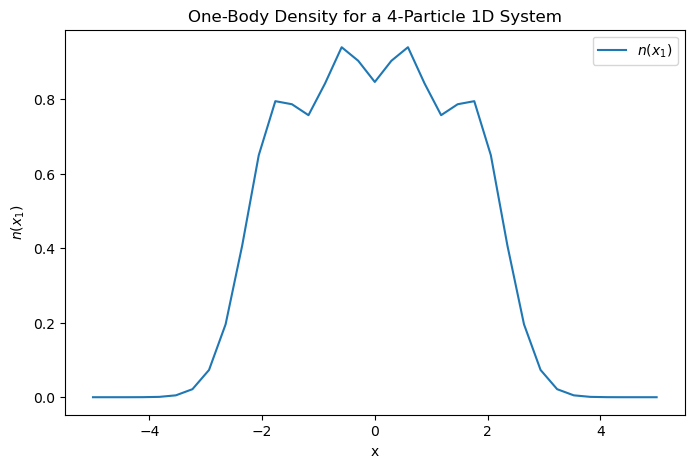

In [12]:
n_particles=4
Ngrid = 35       # Number of grid points per particle coordinate
x_grid = torch.linspace(-L, L, Ngrid)  # shape: (Ngrid,)
mesh = torch.meshgrid(*([x_grid] * n_particles), indexing='ij')
positions = torch.stack([m.reshape(-1) for m in mesh], dim=-1)
positions = positions.unsqueeze(-1)
SD_vals = slater_determinant_from_C_occ_batch(positions, C_occ)  
psi_vals = SD_vals
psi_sq = (psi_vals.abs()**2).view(*([Ngrid] * n_particles))
density = psi_sq.clone()
for axis in sorted(range(1, n_particles), reverse=True):
    density = torch.trapz(density, x_grid, dim=axis)
n_x = n_particles * density  # shape: (Ngrid,)

# --- 7. Plot the one-body density ---
x_vals = x_grid.detach().cpu().numpy()
n_vals = n_x.detach().cpu().numpy()

plt.figure(figsize=(8, 5))
plt.plot(x_vals, n_vals, label=r'$n(x_1)$')
plt.xlabel('x')
plt.ylabel(r'$n(x_1)$')
plt.title(f'One-Body Density for a {n_particles}-Particle 1D System')
plt.legend()
plt.show()

In [13]:
def compute_laplacian_fast_VMC(psi_fn, x, epsilon=1e-3,permutations=None):
    """
    Approximate the Laplacian using a finite difference scheme.
    """
    batch, n_particles, d = x.shape
    laplacian = torch.zeros(batch, 1, device=x.device)

    for i in range(n_particles):
        for j in range(d):
            dx = torch.zeros_like(x)
            dx[:, i, j] = epsilon  # Perturb coordinate (i, j)
            
            psi_plus = psi_fn(x + dx,permutations=permutations).view(-1, 1)
            psi_minus = psi_fn(x - dx,permutations=permutations).view(-1, 1)
            psi_0 = psi_fn(x,permutations=permutations).view(-1, 1)
            
            laplacian += (psi_plus + psi_minus - 2 * psi_0) / (epsilon**2)

    return laplacian


In [14]:
vmc_simulation_optimized(psi_fn_SD, 4, 1, 8000,V=0)

(7.90282479301095, 0.97275)

In [15]:
# 5. Neural Network (PINN) for the Correction Factor f(x;θ)
# =======================
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, n_hidden=1):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.GELU())
        for _ in range(n_hidden):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.GELU())
        layers.append(nn.Linear(hidden_dim, 1))  # output a scalar correction factor
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        # x is of shape (batch_size, n_particles, d)
        # Flatten the input to (batch_size, n_particles * d)
        batch_size = x.shape[0]
        x_flat = x.view(batch_size, -1)
        return self.net(x_flat)


In [32]:
device="cpu"
d = 1
n_particles=4
N_collocation = 400 # Number of collocation points per training iteration
learning_rate = 1e-3
n_epochs = 2000

# Test points
input_dim = n_particles * d
f_net = PINN(input_dim=input_dim, hidden_dim=64, n_hidden=1).to(device)
optimizer = optim.Adam(list(f_net.parameters()), lr=learning_rate)

In [33]:
train_model(0,8.0,f_net,optimizer,n_epochs=n_epochs,sdt_dev=1.9,N_collocation=N_collocation)

Epoch 00000:  Pde Loss = 2.060e-04, Norm Loss = 6.714e+00
Epoch 00010:  Pde Loss = 1.241e-03, Norm Loss = 2.500e+00
Epoch 00020:  Pde Loss = 5.022e-03, Norm Loss = 8.927e-01
Epoch 00030:  Pde Loss = 8.390e-03, Norm Loss = 3.345e-01
Epoch 00040:  Pde Loss = 1.201e-02, Norm Loss = 1.826e-01
Epoch 00050:  Pde Loss = 1.448e-02, Norm Loss = 1.120e-01
Epoch 00060:  Pde Loss = 1.806e-02, Norm Loss = 5.909e-02
Epoch 00070:  Pde Loss = 1.914e-02, Norm Loss = 3.267e-02
Epoch 00080:  Pde Loss = 1.555e-02, Norm Loss = 8.196e-03
Epoch 00090:  Pde Loss = 2.166e-02, Norm Loss = 1.236e-02
Epoch 00100:  Pde Loss = 1.767e-02, Norm Loss = 8.654e-03
Epoch 00110:  Pde Loss = 1.514e-02, Norm Loss = 3.089e-02
Epoch 00120:  Pde Loss = 1.619e-02, Norm Loss = 1.259e-02
Epoch 00130:  Pde Loss = 1.808e-02, Norm Loss = 1.758e-03
Epoch 00140:  Pde Loss = 1.394e-02, Norm Loss = 1.151e-03
Epoch 00150:  Pde Loss = 1.644e-02, Norm Loss = 7.517e-03
Epoch 00160:  Pde Loss = 1.756e-02, Norm Loss = 6.780e-04
Epoch 00170:  

PINN(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

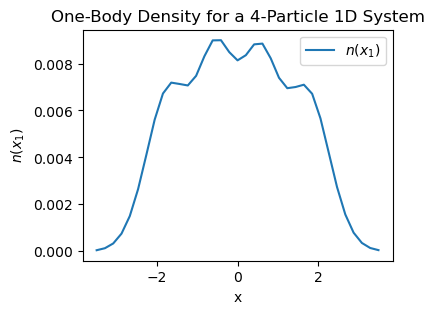

In [36]:
L=3.5
Ngrid = 35       # Number of grid points per particle coordinate
x_grid = torch.linspace(-L, L, Ngrid)  # shape: (Ngrid,)
mesh = torch.meshgrid(*([x_grid] * n_particles), indexing='ij')
positions = torch.stack([m.reshape(-1) for m in mesh], dim=-1)
positions = positions.unsqueeze(-1)
SD_vals = slater_determinant_from_C_occ_batch(positions, C_occ)   # shape: (Ngrid**n_particles, 1)
f_vals  = symmetrized_exp_nn_output(f_net, positions, n_permutations=10)#f_net(positions)#torch.exp(f_net(positions)).view(-1, 1)                        # shape: (Ngrid**n_particles, 1)
psi_vals =  SD_vals * f_vals                            # shape: (Ngrid**n_particles, 1)
psi_sq = (psi_vals.abs()**2).view(*([Ngrid] * n_particles))
density = psi_sq.clone()
for axis in sorted(range(1, n_particles), reverse=True):
    density = torch.trapz(density, x_grid, dim=axis)
n_x = n_particles * density  # shape: (Ngrid,)

# --- 7. Plot the one-body density ---
x_vals = x_grid.detach().cpu().numpy()
n_vals = n_x.detach().cpu().numpy()

plt.figure(figsize=(4, 3))
plt.plot(x_vals, n_vals, label=r'$n(x_1)$')
plt.xlabel('x')
plt.ylabel(r'$n(x_1)$')
plt.title(f'One-Body Density for a {n_particles}-Particle 1D System')
plt.legend()
plt.show()

In [37]:
vmc_simulation_optimized(psi_fn_E, 4, 1, 8000,V=0)

(7.847215313203633, 0.9555)

In [49]:

optimizer = optim.Adam(list(f_net.parameters()), lr=1e-3)
train_model(10,10.9,f_net,optimizer,n_epochs=n_epochs,sdt_dev=2.4,N_collocation=N_collocation,factor=1)

Epoch 00000:  Pde Loss = 2.350e-03, Norm Loss = 4.094e-03
Epoch 00010:  Pde Loss = 3.194e-03, Norm Loss = 2.297e-03
Epoch 00020:  Pde Loss = 2.745e-03, Norm Loss = 5.569e-03
Epoch 00030:  Pde Loss = 2.651e-03, Norm Loss = 1.212e-03


KeyboardInterrupt: 

In [56]:
vmc_simulation_optimized(psi_fn_E, 4, 1, 10000,V=10,delta=0.05)

(12.810683623218537, 0.9261)

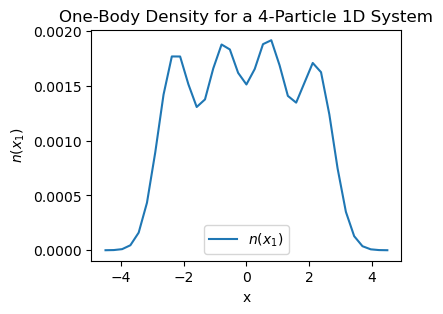

In [59]:
L=4.5
Ngrid = 35       # Number of grid points per particle coordinate
x_grid = torch.linspace(-L, L, Ngrid)  # shape: (Ngrid,)
mesh = torch.meshgrid(*([x_grid] * n_particles), indexing='ij')
positions = torch.stack([m.reshape(-1) for m in mesh], dim=-1)
positions = positions.unsqueeze(-1)
SD_vals = slater_determinant_from_C_occ_batch(positions, C_occ)   # shape: (Ngrid**n_particles, 1)
f_vals  = symmetrized_exp_nn_output(f_net, positions, n_permutations=10)#f_net(positions)#torch.exp(f_net(positions)).view(-1, 1)                        # shape: (Ngrid**n_particles, 1)
psi_vals =  SD_vals * f_vals                            # shape: (Ngrid**n_particles, 1)
psi_sq = (psi_vals.abs()**2).view(*([Ngrid] * n_particles))
density = psi_sq.clone()
for axis in sorted(range(1, n_particles), reverse=True):
    density = torch.trapz(density, x_grid, dim=axis)
n_x = n_particles * density  # shape: (Ngrid,)

# --- 7. Plot the one-body density ---
x_vals = x_grid.detach().cpu().numpy()
n_vals = n_x.detach().cpu().numpy()

plt.figure(figsize=(4, 3))
plt.plot(x_vals, n_vals, label=r'$n(x_1)$')
plt.xlabel('x')
plt.ylabel(r'$n(x_1)$')
plt.title(f'One-Body Density for a {n_particles}-Particle 1D System')
plt.legend()
plt.show()

In [57]:
optimizer = optim.Adam(list(f_net.parameters()), lr=1e-3)
train_model(20,12.5,f_net,optimizer,n_epochs=n_epochs,sdt_dev=2.3,N_collocation=N_collocation,factor=5)

Epoch 00000:  Pde Loss = 1.356e-02, Norm Loss = 3.754e-04
Epoch 00010:  Pde Loss = 8.941e-03, Norm Loss = 4.305e-04
Epoch 00020:  Pde Loss = 5.638e-03, Norm Loss = 1.649e-03
Epoch 00030:  Pde Loss = 4.395e-03, Norm Loss = 1.829e-04
Epoch 00040:  Pde Loss = 4.321e-03, Norm Loss = 3.844e-03
Epoch 00050:  Pde Loss = 3.267e-03, Norm Loss = 7.771e-04
Epoch 00060:  Pde Loss = 3.324e-03, Norm Loss = 2.193e-03
Epoch 00070:  Pde Loss = 3.153e-03, Norm Loss = 1.742e-05
Epoch 00080:  Pde Loss = 3.011e-03, Norm Loss = 1.342e-04
Epoch 00090:  Pde Loss = 3.676e-03, Norm Loss = 5.803e-05
Epoch 00100:  Pde Loss = 2.919e-03, Norm Loss = 2.728e-05
Epoch 00110:  Pde Loss = 2.706e-03, Norm Loss = 8.678e-07
Epoch 00120:  Pde Loss = 2.797e-03, Norm Loss = 9.083e-05
Epoch 00130:  Pde Loss = 3.969e-03, Norm Loss = 5.212e-03
Epoch 00140:  Pde Loss = 3.308e-03, Norm Loss = 1.652e-03
Epoch 00150:  Pde Loss = 3.129e-03, Norm Loss = 1.135e-06
Epoch 00160:  Pde Loss = 3.016e-03, Norm Loss = 3.923e-05
Epoch 00170:  

KeyboardInterrupt: 

In [78]:
vmc_simulation_optimized(psi_fn_E, 4, 1, 16000,V=20,delta=0.08)

(15.66521538707614, 0.9011875)